## Реализация LSTM 

In [173]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import MeanSquaredError, R2Score
import time
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

### Готовим данные

In [174]:
market_data = pd.read_csv('C:/Projects/vsCode/ml_unik_project/data/df_combined.csv', sep=',')
market_data.tail()

,Unnamed: 0,CBOE Volatility Index,Crude Oil Prices: WTI,Crude Oil Prices: Brent,Spred 10-Year and 2-Year Treasury Constant Maturity,"Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis",U.S. Dollars to Euro Spot Exchange Rate,Japanese Yen to U.S. Dollar Spot Exchange Rate,ICE BofA BB US High Yield Index Effective Yield,Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate,Term Premium on a 10 Year Zero Coupon Bond,Economic Policy Uncertainty Index for United States,GSPC_Close,GSPC_High,GSPC_Low,GSPC_Open,GSPC_Volume,GSPC_SMA_50,GSPC_SMA_200,GSPC_EMA_50,GSPC_EMA_200,GSPC_RSI,GSPC_MACD,GSPC_MACD_signal,GSPC_MACD_hist,GSPC_ATR,GSPC_ADX,DJI_Close,DJI_High,DJI_Low,DJI_Open,DJI_Volume,DJI_SMA_50,DJI_SMA_200,DJI_EMA_50,DJI_EMA_200,DJI_RSI,DJI_MACD,DJI_MACD_signal,DJI_MACD_hist,DJI_ATR,DJI_ADX,IXIC_Close,IXIC_High,IXIC_Low,IXIC_Open,IXIC_Volume,IXIC_SMA_50,IXIC_SMA_200,IXIC_EMA_50,IXIC_EMA_200,IXIC_RSI,IXIC_MACD,IXIC_MACD_signal,IXIC_MACD_hist,IXIC_ATR,IXIC_ADX,FTSE_Close,FTSE_High,FTSE_Low,FTSE_Open,FTSE_Volume,FTSE_SMA_50,FTSE_SMA_200,FTSE_EMA_50,FTSE_EMA_200,FTSE_RSI,FTSE_MACD,FTSE_MACD_signal,FTSE_MACD_hist,FTSE_ATR,FTSE_ADX,N225_Close,N225_High,N225_Low,N225_Open,N225_Volume,N225_SMA_50,N225_SMA_200,N225_EMA_50,N225_EMA_200,N225_RSI,N225_MACD,N225_MACD_signal,N225_MACD_hist,N225_ATR,N225_ADX,GDAXI_Close,GDAXI_High,GDAXI_Low,GDAXI_Open,GDAXI_Volume,GDAXI_SMA_50,GDAXI_SMA_200,GDAXI_EMA_50,GDAXI_EMA_200,GDAXI_RSI,GDAXI_MACD,GDAXI_MACD_signal,GDAXI_MACD_hist,GDAXI_ATR,GDAXI_ADX,FCHI_Close,FCHI_High,FCHI_Low,FCHI_Open,FCHI_Volume,FCHI_SMA_50,FCHI_SMA_200,FCHI_EMA_50,FCHI_EMA_200,FCHI_RSI,FCHI_MACD,FCHI_MACD_signal,FCHI_MACD_hist,FCHI_ATR,FCHI_ADX,HSI_Close,HSI_High,HSI_Low,HSI_Open,HSI_Volume,HSI_SMA_50,HSI_SMA_200,HSI_EMA_50,HSI_EMA_200,HSI_RSI,HSI_MACD,HSI_MACD_signal,HSI_MACD_hist,HSI_ATR,HSI_ADX,MXX_Close,MXX_High,MXX_Low,MXX_Open,MXX_Volume,MXX_SMA_50,MXX_SMA_200,MXX_EMA_50,MXX_EMA_200,MXX_RSI,MXX_MACD,MXX_MACD_signal,MXX_MACD_hist,MXX_ATR,MXX_ADX,AXJO_Close,AXJO_High,AXJO_Low,AXJO_Open,AXJO_Volume,AXJO_SMA_50,AXJO_SMA_200,AXJO_EMA_50,AXJO_EMA_200,AXJO_RSI,AXJO_MACD,AXJO_MACD_signal,AXJO_MACD_hist,AXJO_ATR,AXJO_ADX,BVSP_Close,BVSP_High,BVSP_Low,BVSP_Open,BVSP_Volume,BVSP_SMA_50,BVSP_SMA_200,BVSP_EMA_50,BVSP_EMA_200,BVSP_RSI,BVSP_MACD,BVSP_MACD_signal,BVSP_MACD_hist,BVSP_ATR,BVSP_ADX
5018,2024-12-06,12.77,68.58,73.78,0.05,4.15,1.0563,149.78,5.71,7.27,0.439,396.74,6090.270020,6099.970215,6079.979980,6081.379883,3.924830e+09,5873.424385,5481.520298,5879.313246,5485.609779,69.263445,62.533327,55.903556,6.629771,45.380478,24.187273,44642.519531,44923.738281,44596.460938,44824.289062,466910000.0,43205.160547,40481.181914,43300.515528,40690.952672,61.045763,522.410452,516.205862,6.204590,406.378568,28.842369,19859.769531,19863.150391,19734.419922,19743.960938,6.787610e+09,18699.855781,17386.384028,18762.951244,17382.006947,72.212950,283.977127,227.700157,56.276970,221.946197,21.563597,8308.599609,8357.599609,8303.500000,8349.400391,1.058505e+09,8227.641982,8158.233008,8231.561714,8119.829985,57.943178,40.737252,22.192971,18.544281,62.603280,22.656736,39091.171875,39468.468750,38940.441406,39371.558594,101500000.0,38793.518906,38677.582217,38605.964861,37747.873838,54.612542,106.053617,12.707029,93.346588,568.567784,11.150816,20384.609375,20425.859375,20331.240234,20374.539062,61610000.0,19378.592891,18580.481211,19353.911061,18473.793143,73.197089,264.639456,139.367377,125.272079,220.778186,19.810827,7426.879883,7444.720215,7334.140137,7334.270020,72204700.0,7406.473545,7689.662771,7368.020092,7518.781019,59.474419,-22.392290,-50.963056,28.570766,97.324867,13.245460,19865.849609,19934.720703,19566.289062,19611.619141,3.493300e+09,20370.076719,18224.145776,19706.937708,18664.026683,51.751281,-127.589094,-178.069561,50.480467,385.493777,10.789108,51348.800781,51819.761719,51263.921875,51644.519531,178103100.0,51443.521484,53766.500742,51295.538097,52893.836171,55.386261,-97.555120,-312.51

In [175]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Columns: 177 entries, Unnamed: 0 to BVSP_ADX
dtypes: float64(176), object(1)
memory usage: 6.8+ MB


#### Можем удалить timestamp, т.к. данные уже отсортированы

In [176]:
market_data = market_data.drop(['Unnamed: 0'], axis=1)
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5023 entries, 0 to 5022
Columns: 176 entries, CBOE Volatility Index to BVSP_ADX
dtypes: float64(176)
memory usage: 6.7 MB


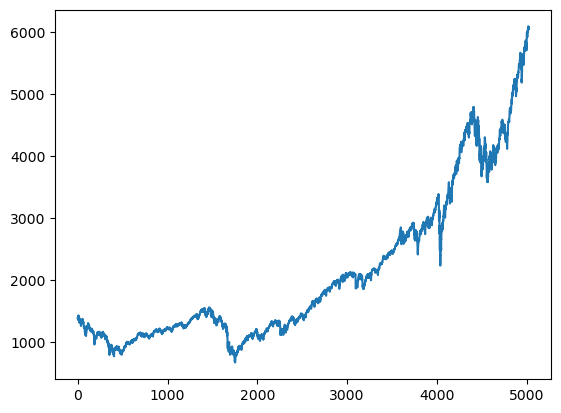

In [177]:
plt.plot(market_data['GSPC_Close'])
plt.show()

#### train | validaton | test

In [178]:
train_size = int(0.75 * len(market_data))
#valid_size = int(0.15 * len(market_data))
test_size = len(market_data) - train_size 

train_data = market_data[:train_size]
#valid_data = market_data[train_size : train_size + valid_size]
test_data = market_data[train_size:]

print('size of train df: ', train_data.shape)
#print('size of valid df: ', valid_data.shape)
print('size of test df: ', test_data.shape)

size of train df:  (3767, 176)
size of test df:  (1256, 176)


#### Нормализация MixMaxScaler()

In [179]:
y_col = 'GSPC_Close'
X_cols = [col for col in train_data.columns if col != y_col]

train_data = train_data.copy()
#valid_data = valid_data.copy()
test_data = test_data.copy()

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_data[X_cols] = scaler_X.fit_transform(train_data[X_cols])
train_data[y_col] = scaler_y.fit_transform(train_data[[y_col]])

#valid_data[X_cols] = scaler_X.transform(valid_data[X_cols])
#valid_data[y_col] = scaler_y.transform(valid_data[[y_col]])

test_data[X_cols] = scaler_X.transform(test_data[X_cols])
test_data[y_col] = scaler_y.transform(test_data[[y_col]])

In [180]:
test_data.tail()

,CBOE Volatility Index,Crude Oil Prices: WTI,Crude Oil Prices: Brent,Spred 10-Year and 2-Year Treasury Constant Maturity,"Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis",U.S. Dollars to Euro Spot Exchange Rate,Japanese Yen to U.S. Dollar Spot Exchange Rate,ICE BofA BB US High Yield Index Effective Yield,Chinese Yuan Renminbi to U.S. Dollar Spot Exchange Rate,Term Premium on a 10 Year Zero Coupon Bond,Economic Policy Uncertainty Index for United States,GSPC_Close,GSPC_High,GSPC_Low,GSPC_Open,GSPC_Volume,GSPC_SMA_50,GSPC_SMA_200,GSPC_EMA_50,GSPC_EMA_200,GSPC_RSI,GSPC_MACD,GSPC_MACD_signal,GSPC_MACD_hist,GSPC_ATR,GSPC_ADX,DJI_Close,DJI_High,DJI_Low,DJI_Open,DJI_Volume,DJI_SMA_50,DJI_SMA_200,DJI_EMA_50,DJI_EMA_200,DJI_RSI,DJI_MACD,DJI_MACD_signal,DJI_MACD_hist,DJI_ATR,DJI_ADX,IXIC_Close,IXIC_High,IXIC_Low,IXIC_Open,IXIC_Volume,IXIC_SMA_50,IXIC_SMA_200,IXIC_EMA_50,IXIC_EMA_200,IXIC_RSI,IXIC_MACD,IXIC_MACD_signal,IXIC_MACD_hist,IXIC_ATR,IXIC_ADX,FTSE_Close,FTSE_High,FTSE_Low,FTSE_Open,FTSE_Volume,FTSE_SMA_50,FTSE_SMA_200,FTSE_EMA_50,FTSE_EMA_200,FTSE_RSI,FTSE_MACD,FTSE_MACD_signal,FTSE_MACD_hist,FTSE_ATR,FTSE_ADX,N225_Close,N225_High,N225_Low,N225_Open,N225_Volume,N225_SMA_50,N225_SMA_200,N225_EMA_50,N225_EMA_200,N225_RSI,N225_MACD,N225_MACD_signal,N225_MACD_hist,N225_ATR,N225_ADX,GDAXI_Close,GDAXI_High,GDAXI_Low,GDAXI_Open,GDAXI_Volume,GDAXI_SMA_50,GDAXI_SMA_200,GDAXI_EMA_50,GDAXI_EMA_200,GDAXI_RSI,GDAXI_MACD,GDAXI_MACD_signal,GDAXI_MACD_hist,GDAXI_ATR,GDAXI_ADX,FCHI_Close,FCHI_High,FCHI_Low,FCHI_Open,FCHI_Volume,FCHI_SMA_50,FCHI_SMA_200,FCHI_EMA_50,FCHI_EMA_200,FCHI_RSI,FCHI_MACD,FCHI_MACD_signal,FCHI_MACD_hist,FCHI_ATR,FCHI_ADX,HSI_Close,HSI_High,HSI_Low,HSI_Open,HSI_Volume,HSI_SMA_50,HSI_SMA_200,HSI_EMA_50,HSI_EMA_200,HSI_RSI,HSI_MACD,HSI_MACD_signal,HSI_MACD_hist,HSI_ATR,HSI_ADX,MXX_Close,MXX_High,MXX_Low,MXX_Open,MXX_Volume,MXX_SMA_50,MXX_SMA_200,MXX_EMA_50,MXX_EMA_200,MXX_RSI,MXX_MACD,MXX_MACD_signal,MXX_MACD_hist,MXX_ATR,MXX_ADX,AXJO_Close,AXJO_High,AXJO_Low,AXJO_Open,AXJO_Volume,AXJO_SMA_50,AXJO_SMA_200,AXJO_EMA_50,AXJO_EMA_200,AXJO_RSI,AXJO_MACD,AXJO_MACD_signal,AXJO_MACD_hist,AXJO_ATR,AXJO_ADX,BVSP_Close,BVSP_High,BVSP_Low,BVSP_Open,BVSP_Volume,BVSP_SMA_50,BVSP_SMA_200,BVSP_EMA_50,BVSP_EMA_200,BVSP_RSI,BVSP_MACD,BVSP_MACD_signal,BVSP_MACD_hist,BVSP_ATR,BVSP_ADX
5018,0.050113,0.398526,0.449215,0.089744,0.617778,0.296253,1.254191,0.134304,0.549067,0.342954,0.549661,2.401602,2.406753,2.394878,2.392978,0.318680,2.431783,2.429718,2.442369,2.469638,0.791357,1.121025,1.111359,0.761349,0.671153,0.342156,1.883407,1.899767,1.886478,1.891444,0.562211,1.931648,1.907783,1.937169,1.946639,0.637405,1.026206,1.055989,0.651646,0.666891,0.336548,2.679643,2.676313,2.671985,2.669632,1.515679,2.618121,2.595530,2.629931,2.628694,0.837612,1.449763,1.362631,0.963491,1.249060,0.311023,1.115564,1.108839,1.119925,1.102799,0.195033,1.136677,1.185581,1.146964,1.173416,0.624010,0.790645,0.739598,0.575167,0.147055,0.240273,1.860877,1.865864,1.854888,1.865965,0.170531,2.022842,2.159329,2.010053,2.128693,0.518061,0.690325,0.641756,0.754260,0.975152,0.055766,1.600971,1.605553,1.601412,1.597670,0.124714,1.587167,1.587635,1.584400,1.605283,0.844057,0.927792,0.769957,1.041185,0.659579,0.235526,1.254076,1.249979,1.249678,1.218340,0.135915,1.264636,1.382590,1.290125,1.370013,0.677332,0.662604,0.553547,0.717404,0.367948,0.104287,0.465958,0.458684,0.456827,0.450624,0.356491,0.510851,0.428333,0.490041,0.454981,0.493590,0.505075,0.466387,0.624323,0.270260,0.038202,0.992182,1.001016,0.994411,1.001162,0.101197,1.009327,1.093249,1.010486,1.080634,0.587064,0.627992,0.518617,0.757101,0.535252,0.133258,1.385679,1.392780,1.402008,1.410444,0.000397,1.448737,1.482125,1.471504,1.522620,0.630526,0.814857,0.805863,0.586001,0.296213,0.299286,1.447487,1.472023,1.467862,1.471351,0.048321,1.582764,1.670780,1.592025,1.710085,0.407554,0.497102,0.483265,0.539218,0.404691,0.267283
5019,0.070158,0.399075,0.448823,0.096154,0.628889,

#### Создание временных окон

In [181]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_column, sequence_length=24):
        self.data = data
        self.target_column = target_column
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        X = self.data.iloc[idx:idx + self.sequence_length].drop(columns=[self.target_column]).values
        
        y = self.data.iloc[idx + self.sequence_length][self.target_column]
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [182]:
sequence_length = 7
target_column = 'GSPC_Close'  

train_dataset = TimeSeriesDataset(train_data, target_column, sequence_length)
#val_dataset = TimeSeriesDataset(valid_data, target_column, sequence_length)
test_dataset = TimeSeriesDataset(test_data, target_column, sequence_length)

X, y = train_dataset[0]
print(f"X shape: {X.shape}, y shape: {y}")
print("len train: ", len(train_dataset))

X shape: torch.Size([7, 175]), y shape: 0.330353707075119
len train:  3760


In [183]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
    print(f"batch {batch_idx}| shape X: {x_batch.shape}, shape y: {y_batch.shape}")
    break

batch 0| shape X: torch.Size([32, 7, 175]), shape y: torch.Size([32])


### Строим модель

In [184]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(f"device: {device}")

device: cuda


In [185]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, fc_size, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        
        # 1st LSTM
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # 2nd LSTM
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Linears
        self.fc1 = nn.Linear(hidden_size2, fc_size)  
        self.sigmoid = nn.Sigmoid()  
        self.fc2 = nn.Linear(fc_size, output_size)  
        
    
    def forward(self, x):
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        
        out, _ = self.lstm2(out)
        out = self.dropout2(out)

        out = out[:, -1, :]  
        
        out = self.fc1(out)  
        out = self.sigmoid(out)  
        out = self.fc2(out)  
        
        return out

In [186]:
input_size = 175  
hidden_size1 = 512  
hidden_size2 = 256 
fc_size = 16      
output_size = 1     
dropout_rate = 0.2
num_epochs = 50
learning_rate = 0.0001

model = LSTMModel(input_size, hidden_size1, hidden_size2, fc_size, output_size, dropout_rate).to(device)
print(model)

LSTMModel(
  (lstm1): LSTM(175, 512, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(512, 256, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=16, bias=True)
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [187]:
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [188]:
X_example = torch.rand(BATCH_SIZE, sequence_length, input_size).to(device)

y_pred = model(X_example)
print(f"output shape: {y_pred.shape}")  

output shape: torch.Size([32, 1])


### Обучаем модель

In [189]:
def train_model(model_nn, train_loader, test_loader, optimizer, loss_fn, num_epochs, device):
    train_r2 = R2Score().to(device)
    test_r2 = R2Score().to(device)
    
    for epoch in range(num_epochs):
        start = time.time()
        
        train_loss = 0.0
        train_iters = 0
        
        model_nn.train()
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)  
            y = y.unsqueeze(-1)  
            
            y_pred = model_nn(X)  
            
            optimizer.zero_grad()  
            loss = loss_fn(y_pred, y)  
            loss.backward()  
            optimizer.step()  
            
            train_loss += loss.item()  
            train_iters += 1
            
            train_r2.update(y_pred, y)
        
        train_r2_out = train_r2.compute()
        train_r2.reset()

        test_loss = 0.0
        test_iters = 0
        
        model_nn.eval()
        
        with torch.no_grad():  
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)  
                y = y.unsqueeze(-1)  
                
                y_pred = model_nn(X)  
                
                loss = loss_fn(y_pred, y)  
                
                test_loss += loss.item()  
                test_iters += 1
                
                test_r2.update(y_pred, y)
        
        test_r2_out = test_r2.compute()
        test_r2.reset()

        if (epoch < 9):
            print(f"Эпоха: 0{epoch+1} | Время: {time.time()-start:.2f} сек | "
              f"Train Loss: {train_loss/train_iters:.4f} | Train R²: {train_r2_out:.2f} | "
              f"Test Loss: {test_loss/test_iters:.4f} | Test R²: {test_r2_out:.2f}")
        else:
            print(f"Эпоха: {epoch+1} | Время: {time.time()-start:.2f} сек | "
                f"Train Loss: {train_loss/train_iters:.4f} | Train R²: {train_r2_out:.2f} | "
                f"Test Loss: {test_loss/test_iters:.4f} | Test R²: {test_r2_out:.2f}")


In [190]:
train_model(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Эпоха: 01 | Время: 10.54 сек | Train Loss: 0.0378 | Train R²: 0.28 | Test Loss: 0.7610 | Test R²: -3.83
Эпоха: 02 | Время: 10.41 сек | Train Loss: 0.0515 | Train R²: 0.02 | Test Loss: 0.8330 | Test R²: -4.31
Эпоха: 03 | Время: 10.84 сек | Train Loss: 0.0247 | Train R²: 0.53 | Test Loss: 0.8128 | Test R²: -4.18
Эпоха: 04 | Время: 10.68 сек | Train Loss: 0.0089 | Train R²: 0.83 | Test Loss: 0.7575 | Test R²: -3.81
Эпоха: 05 | Время: 10.34 сек | Train Loss: 0.0040 | Train R²: 0.92 | Test Loss: 0.7045 | Test R²: -3.46
Эпоха: 06 | Время: 10.66 сек | Train Loss: 0.0057 | Train R²: 0.89 | Test Loss: 0.6671 | Test R²: -3.22
Эпоха: 07 | Время: 10.20 сек | Train Loss: 0.0045 | Train R²: 0.91 | Test Loss: 0.6331 | Test R²: -2.99
Эпоха: 08 | Время: 10.34 сек | Train Loss: 0.0037 | Train R²: 0.93 | Test Loss: 0.6078 | Test R²: -2.83
Эпоха: 09 | Время: 10.70 сек | Train Loss: 0.0031 | Train R²: 0.94 | Test Loss: 0.5877 | Test R²: -2.69
Эпоха: 10 | Время: 10.58 сек | Train Loss: 0.0029 | Train R²: 0.

KeyboardInterrupt: 